# Similarity explanations for 20 news groups dataset

In this notebook we apply the similarity explanation method to a feed forward neural network (FFNN) trained on the 20 news group dataset. 

The 20 news group dataset is a corpus of 18846 text documents (emails) divided in 20 sections. The FFNN is trained to classify each document in the correct section. The model uses pre-trained sentence embeddings as input features, which are obtained from raw text using a [pretrained transformer](https://www.sbert.net/docs/pretrained_models.html). 

Given an input document of interest, the similarity explanation method used here aims to find text documents in the train dataset that are similar to the document of interest according to "how the model sees them", meaning that the similarity metric makes use of the gradients of the model's loss function with respect to the model's parameters.

The similarity explanation tool is implemented with both pytorch and tensorflow backends. In this example, we will use the pytorch backend.

A more detailed description of the method can be found [here](link_to_method). The implementation follows  [Charpiat et al., 2019](https://papers.nips.cc/paper/2019/file/c61f571dbd2fb949d3fe5ae1608dd48b-Paper.pdf) and  [Hanawa et al. 2021](https://arxiv.org/pdf/2006.04528.pdf).

In [2]:
import numpy as np
import pandas as pd
import os
import torch
import re
import string
import matplotlib.pyplot as plt
import torch.nn as nn
from termcolor import colored
from torch.utils.data import DataLoader
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from alibi.explainers.similarity.grad import GradientSimilarity

In [42]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y].astype('float32')

class TorchDataset(torch.utils.data.Dataset):
    """Utility class to create a torch dataloader from numpy arrays.
    """
    def __init__(self, *indexables):
        self.indexables = indexables

    def __getitem__(self, idx):
        output = tuple(indexable[idx] for indexable in self.indexables)
        return output if len(output) > 1 else output[0]

    def __len__(self):
        return len(self.indexables[0])
    
def appendInt(num):
    """Converts integer into cardials (ex. 1 -> 1st, 2 -> 2nd, etc.)
    """
    if num > 9:
        secondToLastDigit = str(num)[-2]
        if secondToLastDigit == '1':
            return 'th'
    lastDigit = num % 10
    if (lastDigit == 1):
        return 'st'
    elif (lastDigit == 2):
        return 'nd'
    elif (lastDigit == 3):
        return 'rd'
    else:
        return 'th'

## Load data

Loading and preparing the 20 news group data set.

In [26]:
example_idx = 4

print("Loading 20 news groups dataset")
data = fetch_20newsgroups(shuffle=True, random_state=1, subset='all',
                          remove=('headers', 'footers', 'quotes'),
                          return_X_y=False)
X, y = np.asarray(data.data), data.target
target_names = data.target_names
df = pd.DataFrame({'text': X, 'labels': y})

print("Cleaning text")
df['text_cleaned'] = df['text'].str.replace('\s+',' ')
df['text_cleaned'] = df['text_cleaned'].str.strip()
df['text_cleaned'] = df['text_cleaned'].str.slice(0,131072)
df = df.replace('', np.NaN).dropna()
df = df.drop_duplicates(subset='text_cleaned')
print('')

print(colored("Sample document before cleaning", 'red'))
print(f"{df['text'][example_idx]}")
print('')
print(colored("Sample document after cleaning", 'red'))
print(f"{df['text_cleaned'][example_idx]}")
print('')

print("Splitting train - test")
df_train, df_test = train_test_split(df, test_size=0.2)
X_train, y_train = df_train['text_cleaned'].values, df_train['labels'].values
X_test, y_test = df_test['text_cleaned'].values, df_test['labels'].values
y_train, y_test = to_categorical(y_train, num_classes=20), to_categorical(y_test, num_classes=20)
print(f"X_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

Loading 20 news groups dataset
Cleaning text


The default value of regex will change from True to False in a future version.



Sample document before cleaning

So its an automatic? Don't know if US spec=CDN spec. for Maximas.


If it is the first set of brake pads on front, then this is fine. My car
eats a set every 15k miles or so. The fact that he is replacing the
muffler too is also ok.


The mileage is fairly low - but typical fwd stuff is CV joints. Check
the maintenance records with the manufacturers requirements for valve
adjustments, timing belt changes and so on.

The 60k mile service is often expensive, so make sure he has done everything.


Well, this is one of the commonly cited methods for identifying a
car with highway miles. 
Might check the gas pedal wear too. Ask him how many sets of tires he
has been through. A highway car might have squeezed by on 2 sets,
a hard driven car 6-10 sets.



Well, the Maxima should be pretty reliable - but if its out of warranty
you should get it checked out by someone knowledgeable first. Stuff
for Japanese cars can be expensive.


1995 model year, I believe. 


## Define and train model

We define and train a pytorch classifier using sentence embeddings as inputs.

### Define model

In [28]:
class EmbeddingModel:
    """Pre-trained sentence transformer wrapper.
    """
    def __init__(
        self,
        model_name: str = 'paraphrase-MiniLM-L6-v2',  # https://www.sbert.net/docs/pretrained_models.html
        max_seq_length: int = 200,
        batch_size: int = 32,
        device: torch.device = None
    ) -> None:
        if not isinstance(device, torch.device):
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.encode_text = SentenceTransformer(model_name).to(device)
        self.encode_text.max_seq_length = max_seq_length
        self.batch_size = batch_size
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.encode_text.encode(x, 
                                       convert_to_numpy=True, 
                                       batch_size=self.batch_size,
                                       show_progress_bar=False)

class Classifier(nn.Module):
    """FFNN classifier with pretrained sentence embeddings inputs.
    """
    def __init__(
        self, 
        n_classes= 20
    ) -> None:
        """ Text classification model from sentence embeddings. """
        super().__init__()
        self.head = nn.Sequential(nn.Linear(384, 256), 
                                  nn.LeakyReLU(.1), 
                                  nn.Dropout(.5), 
                                  nn.Linear(256, n_classes))
        
    def forward(self, sentence_embeddings) -> torch.Tensor:
        return self.head(sentence_embeddings)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

### Get sentence embeddings and define dataloaders

In [30]:
embedding_model = EmbeddingModel(device=device)

print('Getting train embeddings')    
embeddings_train = embedding_model(X_train)
train_loader = DataLoader(TorchDataset(torch.Tensor(embeddings_train).to(device), 
                                       torch.Tensor(y_train).to(device)), 
                          batch_size=32, 
                          shuffle=True)

print('Getting test embeddings')  
embeddings_test = embedding_model(X_test)
test_loader = DataLoader(TorchDataset(torch.Tensor(embeddings_test).to(device), 
                                      torch.Tensor(y_test).to(device)), 
                         batch_size=32, 
                         shuffle=False)

Getting train embeddings
Getting test embeddings


### Train model

In [31]:
epochs = 3

# initialize classifier
model = Classifier().to(device)
print('Training classifier')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(epochs):
    for x, y in tqdm(train_loader):
        y_hat = model(x)
        optimizer.zero_grad()
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()

Training classifier


100%|███████████████| 457/457 [00:00<00:00, 1103.87it/s]


### Evaluate model

Evaluating the model on train and test set. Since the dataset is well balanced, we only consider accuracy as evaluation metric.

In [32]:
def eval_model(model, loader):
    model.eval()
    logits, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            y_hat = model(x)
            logits += [y_hat.cpu().numpy()]
            labels += [y.cpu().numpy()]
    logits = np.concatenate(logits, 0)
    preds = np.argmax(logits, 1)
    labels = np.concatenate(labels, 0)
    accuracy = (preds == labels.argmax(axis=1)).mean()
    print(f'Accuracy: {accuracy:.3f}')
    
print('Train set evaluation')
eval_model(model, train_loader)
print('Test set evaluation')
eval_model(model, test_loader)

Train set evaluation
Accuracy: 0.723
Test set evaluation
Accuracy: 0.674


## Find similaraties 

Selecting a reference set of 1000 random samples from the training set. The `GradientSimilarity` explainer will find the most similar instances among those. This downsampling step is performed in order to speed up the `fit` step.

In [33]:
idxs_ref = np.random.choice(len(X_train), 1000, replace=False)
X_ref = X_train[idxs_ref]
embeddings_ref = embeddings_train[idxs_ref]
y_ref = y_train[idxs_ref]

Initializing a `GradientSimilarity` explainer instance.

In [34]:
gsm = GradientSimilarity(model, 
                         loss_fn, 
                         precompute_grads=True, 
                         sim_fn='grad_cos', 
                         backend='pytorch', 
                         device=device)

Fitting the explainer on the reference data.

In [35]:
gsm.fit(embeddings_ref, y_ref)

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_cos',
              'store_grads': True,
              'backend_name': 'pytorch',
              'task_name': 'classification'}
            ,
  'version': '0.6.6dev'}
)

Selecting 5 random instances from the test set.

In [36]:
idxs_samples = np.random.choice(len(X_test), 5, replace=False)
X_sample, embeddings_sample, y_sample = X_test[idxs_samples], embeddings_test[idxs_samples], y_test[idxs_samples]

Getting predictions and explanations for each of the 5 test samples.

In [37]:
preds = model(torch.Tensor(embeddings_sample).to(device)).detach().cpu().numpy().argmax(axis=1)
expls = gsm.explain(embeddings_sample, y_sample)

## Visualizations 

Building a dictionary for each sample for visualization purposes. 
Each dictionary contains
* The original text document `x` (not the embedding representation).
* The corresponding label `y`.
* The corresponding model's prediction `pred`.
* The reference instances ordered by similarity `x_sim`.
* The corresponding reference labels ordered by similarity `y_sim`.
* The corresponding model's predictions for the reference set `preds_sim`.

In [38]:
ds = []
for j in range(len(embeddings_sample)):
    y_sim = y_ref[expls.data['ordered_indices'][j]].argmax(axis=1)
    X_sim = X_ref[expls.data['ordered_indices'][j]]
    sim_embedding = embeddings_ref[expls.data['ordered_indices'][j]]
    preds_sim = model(torch.Tensor(sim_embedding).to(device)).detach().cpu().numpy().argmax(axis=1)

    d = {'x': X_sample[j], 
         'y': y_sample[j].argmax(), 
         'pred':preds[j],
         'x_sim': X_sim,
         'y_sim': y_sim, 
         'preds_sim': preds_sim}
    ds.append(d)

### Most similar instances

Showing the most similar instance for each of the test instances.

In [43]:
for sample_nb in range(5):
    print(colored(f"Sample nb {sample_nb}", 'blue'))
    print(colored("===========", 'blue'))
    print('')
    
    print(colored("Original instance - ", 'red'), 
          colored(f"Label: {target_names[ds[sample_nb]['y']]} - ", 'red'), 
          colored(f"Prediction: {target_names[ds[sample_nb]['pred']]}", 'red'))
    print(f"{ds[sample_nb]['x']}")
    print('')
    
    for i in range(3):
        print(colored(f"{i+1}{appendInt(i+1)} most similar instance - ", 'red'), 
              colored(f"Label: {target_names[ds[sample_nb]['y_sim'][i]]} - ", 'red'), 
              colored(f"Prediction: {target_names[ds[sample_nb]['preds_sim'][i]]}", 'red'))
        print(f"{ds[sample_nb]['x_sim'][i]}")
        print('')

Sample nb 0

Original instance -  Label: rec.autos -  Prediction: misc.forsale
Two-volume soft-cover repair manuals for all models of '91 Toyota Celicas. (Probably good for '92 models as well.) Like new condition. These are the manuals used by the Toyota dealers' mechanics - they normally cost over $80 new. $50 OBO

1st most similar instance -  Label: rec.autos -  Prediction: rec.autos
Any one with experience in having a centreforce clutch (or any other) on his/her car? I'm considering to replace my old stock clutch on my 90 CRX Si. What is a fair price?

2nd most similar instance -  Label: rec.autos -  Prediction: rec.autos
I have been looking at buying a 1989 Jeep Laredo and was wondering if anyone had any bad or good experiences with this model. Is it all that much different than the other YJs? It looks, feels and sounds like a nice vehicle even thought the price is rather steep for an '89 (12K Canadian).

3rd most similar instance -  Label: rec.autos -  Prediction: rec.autos
The Ci

### Most similar labels distributions 

Showing the average similarity scores for each group of instances in the reference set belonging to the same true class and to same predicted class. 

In [40]:
def plot_distributions(ds, expls, figsize=(20, 5)):

    for i in range(len(ds)):
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=False)
        d = ds[i]

        y_sim = d['y_sim']
        preds_sim = d['preds_sim']
        y = d['y']
        pred = d['pred']
        df_ditribution = pd.DataFrame({'y_sim': y_sim, 
                                       'preds_sim': preds_sim, 
                                       'scores': expls.data['scores'][i]})
        print(colored(f"Sample nb {i}", 'blue'))
        print(colored("===========", 'blue'))
        print('')

        print(colored("Original instance", 'red'))
        print(colored(f"Label: section {d['y']}, {target_names[d['y']]}", 'red')) 
        print(colored(f"Prediction: section {d['pred']}, {target_names[d['pred']]}", 'red'))
        print(f"{d['x']}")
        
        df_y = df_ditribution.groupby('y_sim')['scores'].mean().sort_values(ascending=False)
        df_y.plot(kind='bar', ax=axes[0])
        axes[0].set_title("Averaged scores for each true class in reference set \n")
        df_preds = df_ditribution.groupby('preds_sim')['scores'].mean().sort_values(ascending=False)
        df_preds.plot(kind='bar', ax=axes[1])
        axes[1].set_title("Averaged scores for each predicted class in reference set \n")

        plt.show()

Sample nb 0

Original instance
Label: section 7, rec.autos
Prediction: section 6, misc.forsale
Two-volume soft-cover repair manuals for all models of '91 Toyota Celicas. (Probably good for '92 models as well.) Like new condition. These are the manuals used by the Toyota dealers' mechanics - they normally cost over $80 new. $50 OBO


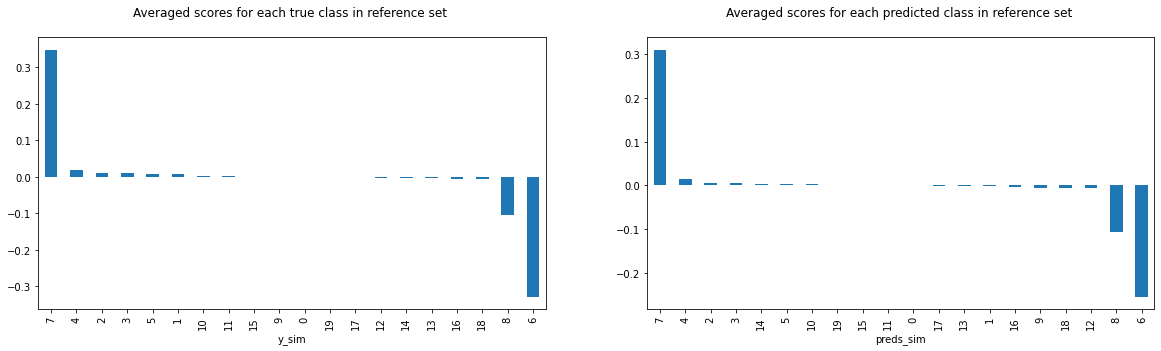

Sample nb 1

Original instance
Label: section 17, talk.politics.mideast
Prediction: section 17, talk.politics.mideast
Bill Coleman writes... (responding to a discussion about a mosque in Jerusalem allegedly having been destroyed by Israel) BC> In today's Jerusalem Post Magazine there is a feature story about the BC> ongoing restoration of synagogues in the Jewish Quarter. The author, BC> Leah Abramowitz, writes that there were FIFTY-SEVEN synagogues in the BC> quarter in 1948, ALL of which were destroyed, some, she says, used as BC> donkey stables. The building shells, that is. BC> BC> I still find it really, really hard to understand why the demolition BC> of the buildings in front of the Kotel continues to evoke more outrage BC> than this. Everything is so much cheaper when it happens to the Jews. BC> BC> Why? The double standard of human behavior regarding the Jews must be manitained. A perfect example is the outcry over the temporary removal of 400 men who advocated murdering Jews 

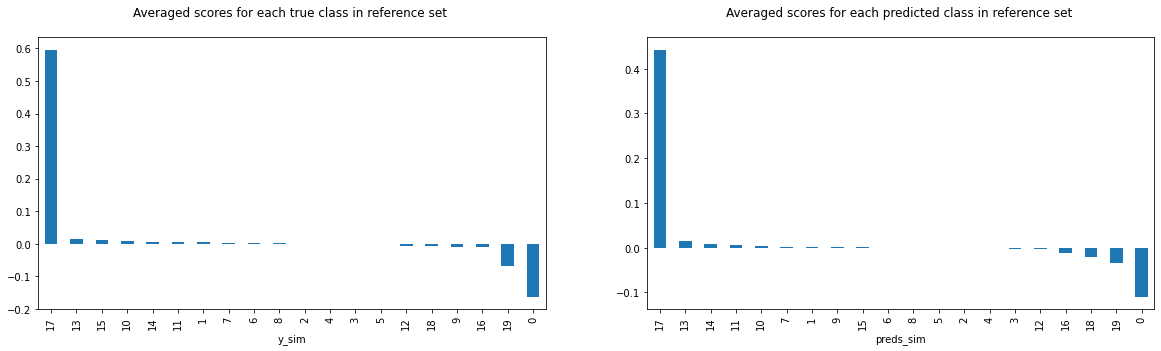

Sample nb 2

Original instance
Label: section 4, comp.sys.mac.hardware
Prediction: section 6, misc.forsale
I have a 512k VRAM chip for sale. Worked fine in my LCII and will give 256 colors on 640 x 480 size screen. Asking $50. I'll cover postage. Speaking of which, does anyone know what the best way to send a chip is. I have a plastic antistatic sleeve, but what's the best way to send it? In an envelope? First class? All info appreciated.


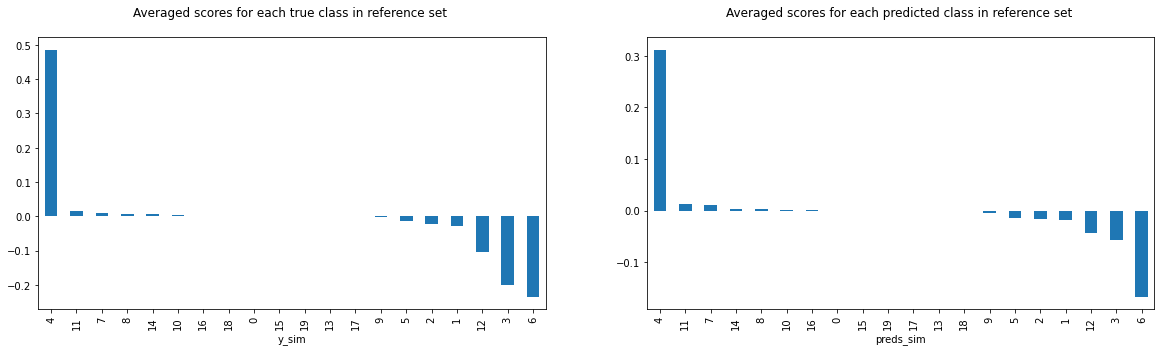

Sample nb 3

Original instance
Label: section 14, sci.space
Prediction: section 14, sci.space
Hmmmm.... The prefix "peri-" is Greek, not Latin, so it's usually used with the Greek form of the name of the body being orbited. (That's why it's "perihelion" rather than "perisol", "perigee" rather than "periterr", and "pericynthion" rather than "perilune".) So for Jupiter I'd expect it to be something like "perizeon".) :^)


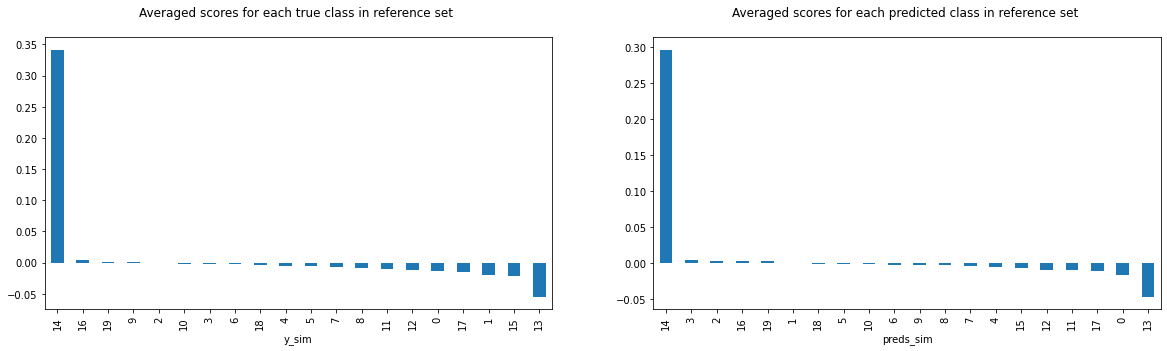

Sample nb 4

Original instance
Label: section 2, comp.os.ms-windows.misc
Prediction: section 2, comp.os.ms-windows.misc
(stuff deleted) This sounds like what happened to my HD a month ago. My HD was stacked with Stacker v.2.0 (I run Dos5) Suddenly everything hung up, and most of the HD got corrupted (directories changed into unreadable files with 'funny' names). In other words: it is probably just the doubledisk part of Dos6 that is troublesome. I now use Stacker v 3.0, and so far I have had no trouble. -------------------------------------------------------------------------- Elisabeth Bull e_mail: eliza@swix.nvg.unit.no


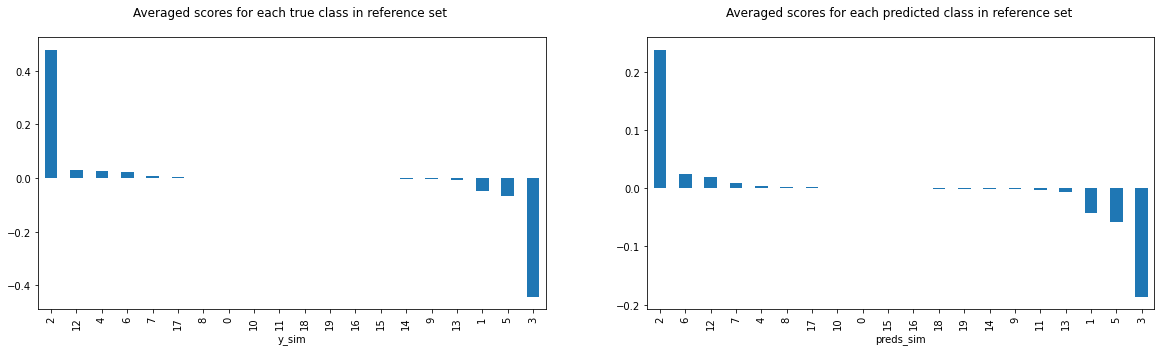

In [41]:
plot_distributions(ds, expls)